In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MISCELLANEOUS
from epw import epw
from pythermalcomfort.models import pmv, adaptive_ashrae, clo_tout
from pythermalcomfort import psychrometrics

In [3]:
environmentalArray = np.load('data/indoor-environment.npy')

ta, rh, tr, vel = np.split(environmentalArray, 4, axis=0)

print(f'Arrays of shape {ta.shape} [r=grid-point, c=hour] imported.')

# variable used to reshape arrays later
grid_length = len(ta)

Arrays of shape (504, 8760) [r=grid-point, c=hour] imported.


In [4]:
weather_file = epw()
weather_file.read(r'data/AUS_QLD_Brisbane.Intl.AP.945780_10_BR_CZ0205_RMY2012C.epw')

# Generate lists of outdoor temperature values
outdoor_temperatures = weather_file.dataframe['Dry Bulb Temperature']
outdoor_temperatures_six_am = outdoor_temperatures[6::24].reset_index()

# create array of dynamic clo values for PMV based on outdoor temperature (6am)
daily_clo_values = clo_tout(tout=outdoor_temperatures_six_am['Dry Bulb Temperature'].to_list())
hourly_clo_values = np.repeat(daily_clo_values, 24)
clo = np.tile(hourly_clo_values, (grid_length, 1))

In [5]:
pmvInput = np.vstack((ta.flatten(), rh.flatten(), tr.flatten(), vel.flatten(), clo.flatten()))
pmvDf = pd.DataFrame(pmvInput.transpose(), columns=['ta','rh','tr','vel', 'clo']).round(2)
pmv_array = pmv(pmvDf.ta, pmvDf.tr.round(decimals=1), pmvDf.vel, pmvDf.rh, 1.1, pmvDf.clo, limit_inputs=False).to_numpy()
pmvPredictions = pmv_array.reshape(grid_length,8760)

In [6]:
# Adaptive Comfort Model

dbt = outdoor_temperatures.to_numpy()
dbt_simple = dbt.repeat(repeats=grid_length, axis=0) # repeat outdoor temperature for each grid point

adaptiveInput = np.vstack((ta.flatten(), tr.flatten(), dbt_simple, vel.flatten()))
adaptiveDf = pd.DataFrame(adaptiveInput.transpose(), columns=['ta','tr','dbt','vel']).round(2)
adaptiveDf['top']  = psychrometrics.t_o(adaptiveDf.ta, adaptiveDf.tr, adaptiveDf.vel) # top = operative temperature

# use 80% acceptability as threshold
adaptiveDf['tmp_cmf_80_low'] = adaptive_ashrae(adaptiveDf.ta, adaptiveDf.tr, adaptiveDf.dbt, adaptiveDf.vel, limit_inputs=False)['tmp_cmf_80_low']
adaptiveDf['tmp_cmf_80_up'] = adaptive_ashrae(adaptiveDf.ta, adaptiveDf.tr, adaptiveDf.dbt, adaptiveDf.vel, limit_inputs=False)['tmp_cmf_80_up']

# group Adaptive predictions into 3 classes: cold, neutral, warm
conditions = [
    (adaptiveDf['top'] <= adaptiveDf['tmp_cmf_80_low']),
    (adaptiveDf['top'] > adaptiveDf['tmp_cmf_80_low']) & (adaptiveDf['top'] < adaptiveDf['tmp_cmf_80_up']),
    (adaptiveDf['top'] >= adaptiveDf['tmp_cmf_80_up'])
    ]

values = [1, 0, -1]

adaptiveDf['adaptive'] = np.select(conditions, values)
adaptive_array = adaptiveDf['adaptive'].to_numpy()
adaptivePredictions = adaptive_array.reshape(grid_length,8760)

In [7]:
np.save('data/output/pmvPredictions.npy', pmvPredictions)
np.save('data/output/adaptivePredictions.npy', adaptivePredictions)

In [8]:
choices = [1, -1, 0]

pmvConditions = [pmvPredictions > 0.5, pmvPredictions < -0.5, abs(pmvPredictions) <= 0.5]
pmvBinned = np.select(pmvConditions, choices, default=pmvPredictions) 
pmvBinned = pmvBinned * -1

In [17]:
# Generate array of hourly mean prediction in grid
#! Wrap in flexible function
hourly_mean = pmvPredictions.mean(axis=0)
hourly_var = pmvPredictions.var(axis=0)
hourly_heterogeneity = pmvPredictions.max(axis=0) - pmvPredictions.min(axis=0)
annual_point_heterogeneity = pmvPredictions.max(axis=1) - pmvPredictions.min(axis=1)

# Evaluate using numpy functions
print('PMV:')
discomfort_hourly_mean = round(np.count_nonzero((abs(hourly_mean) >= 0.5)) / 8760, ndigits=3)
print(f'Overall discomfort: {discomfort_hourly_mean}')

warm_discomfort = round(np.count_nonzero((hourly_mean <= -0.5)) / 8760, ndigits=3)
print(f'Warm discomfort: {warm_discomfort}')

cold_discomfort = round(np.count_nonzero((hourly_mean >= 0.5)) / 8760, ndigits=3)
print(f'Cold discomfort: {cold_discomfort}')

PMV:
Overall discomfort: 0.752
Warm discomfort: 0.407
Cold discomfort: 0.344


{'whiskers': [<matplotlib.lines.Line2D at 0x119efd7f0>,
 'caps': [<matplotlib.lines.Line2D at 0x119efdd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x119ed3050>],
 'medians': [<matplotlib.lines.Line2D at 0x119efe1e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x119efe450>],
 'means': []}

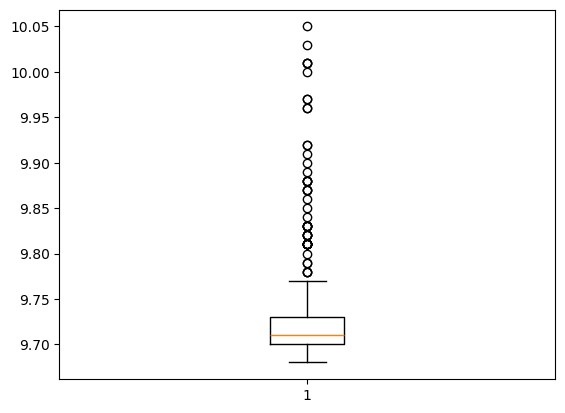

In [18]:
plt.boxplot(annual_point_heterogeneity)

In [10]:
def compute_sta(prediction_array, percentage_area=0.5):
    """
    Computes sTA based on simulated indoor environmental data.

    Args:
        prediction_array (numpy.ndarray): 2D array containing predictions of spatial thermal preference.
        percentage_area (float, optional): Percentage of area threshold for sTA; defaults to 0.5.

    Returns:
        comfort_hours (numpy.ndarray): 2D array containing a boolean comfort prediction for each grid point.
        hourly_autonomy (numpy.ndarray): 1D array where each element represents the hourly sTA.
        spatial_autonomy (float): Annual sTA depending on specified percentage area.
    """

    comfort_hours = np.where(abs(prediction_array) <= 0.5, 1, 0)

    hourly_autonomy = np.sum(comfort_hours, axis=0) / prediction_array.shape[0]
    spatial_autonomy = np.sum( np.where(hourly_autonomy > percentage_area, 1, 0)) / prediction_array.shape[1]

    return spatial_autonomy, hourly_autonomy, comfort_hours


def plot_sta(predictions, algorithm, width=10):
    """
    Plots spatial Thermal Autonomy.

    Args:
        predictions (numpy.ndarray): A 2D array of predictions (e.g. ML, PMV) to plot.
        algorithm (str): The algorithm used to generate the predictions (e.g. 'ML', 'PMV').
        width (int, optional): The width of the plot. Defaults to 10.
    """
    plt.figure(figsize=(width,0.5*width), dpi=500)
    plt.imshow(np.sort(predictions, axis=0), cmap='bwr_r',interpolation='bicubic', aspect=2, alpha=0.75, vmax=1,vmin=-1)
    plt.title(f"Model: {algorithm}, spatial Thermal Autonomy: {compute_sta(predictions)[0].round(decimals=2)}", font='Helvetica')
    plt.xlabel("Time [h]")
    plt.ylabel("Grid points [-]")

    xticks = [15.5*24,      #JAN
              (32+15.5)*24, #FEB
              (60+15.5)*24, #etc.
              (91+15.5)*24,
              (15.5+121)*24,
              (15.5+152)*24,
              (15.5+182)*24,
              (15.5+213)*24,
              (15.5+243)*24,
              (15.5+274)*24,
              (15.5+304)*24,
              (15.5+334)*24]
    
    xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    plt.xticks(ticks=xticks,labels=xlabels)

    plt.show()

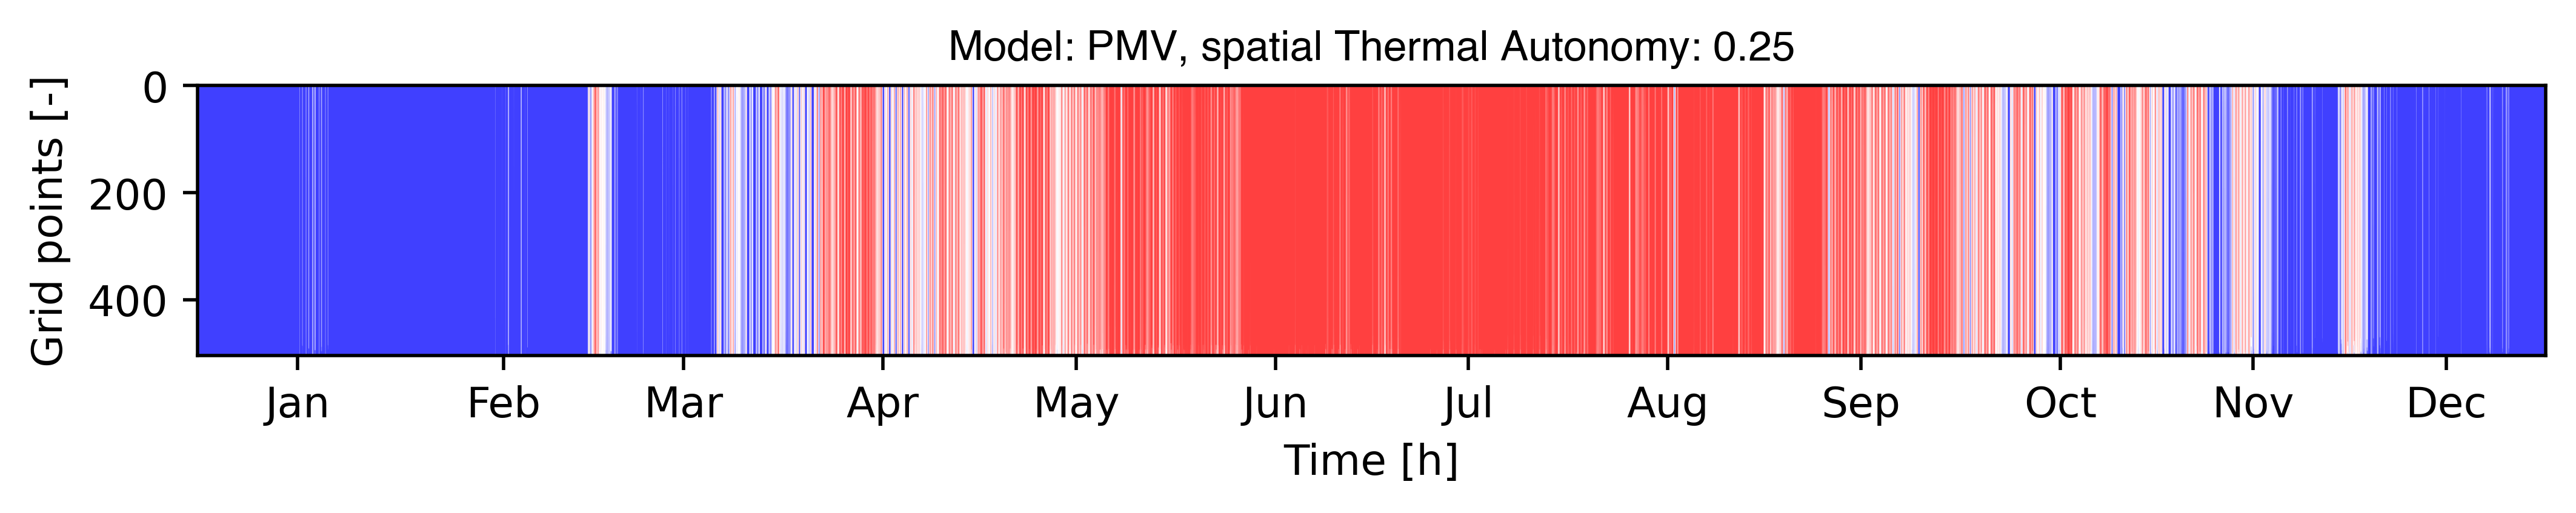

In [11]:
plot_sta(pmvPredictions, 'PMV')

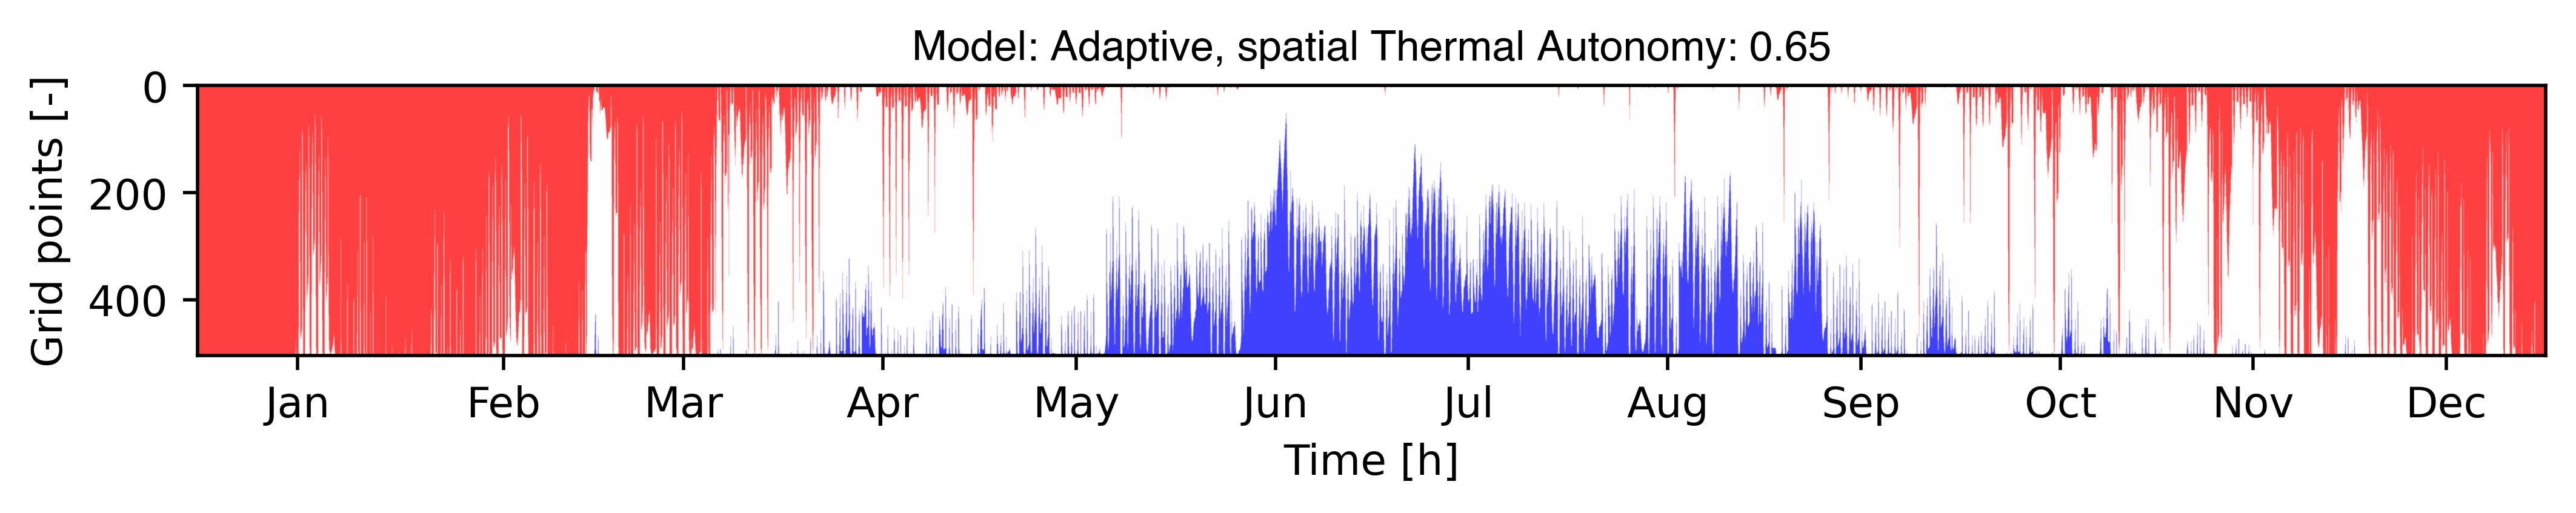

In [12]:
plot_sta(adaptivePredictions, 'Adaptive')

In [13]:
def daily_plot(arr:np.array, days=365, colorbar=False):
    """_summary_

    Args:
        arr (np.array): Requires an array of 8760 hourly comfort condition values
        colorbar (bool, optional): Option to include colorbar. Defaults to False.
    """

    if days == 365:
        xticks = [0, 32, 60,91,121,152,182,213,243,274,304,334]
        xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        yticks = [-0.5,5.5,11.5,17.5,23.5]
        ylabels = [0,6,12,18,24]

    plt.figure(figsize=(8,6), dpi=300)
    plt.imshow(arr.reshape((24,days),order='F'), cmap='binary_r', interpolation='nearest', aspect=5, origin='lower')
    # plt.colorbar(location='bottom')

    plt.xticks(ticks=xticks,labels=xlabels,fontsize=7, font='Helvetica')
    plt.yticks(ticks=yticks,labels=ylabels,fontsize=7, font='Helvetica')

    plt.xlabel('Time [d]', font='Helvetica')
    plt.ylabel('Time [h]', font='Helvetica')
    
    if colorbar:
        plt.colorbar(location='bottom')
    
    plt.show()

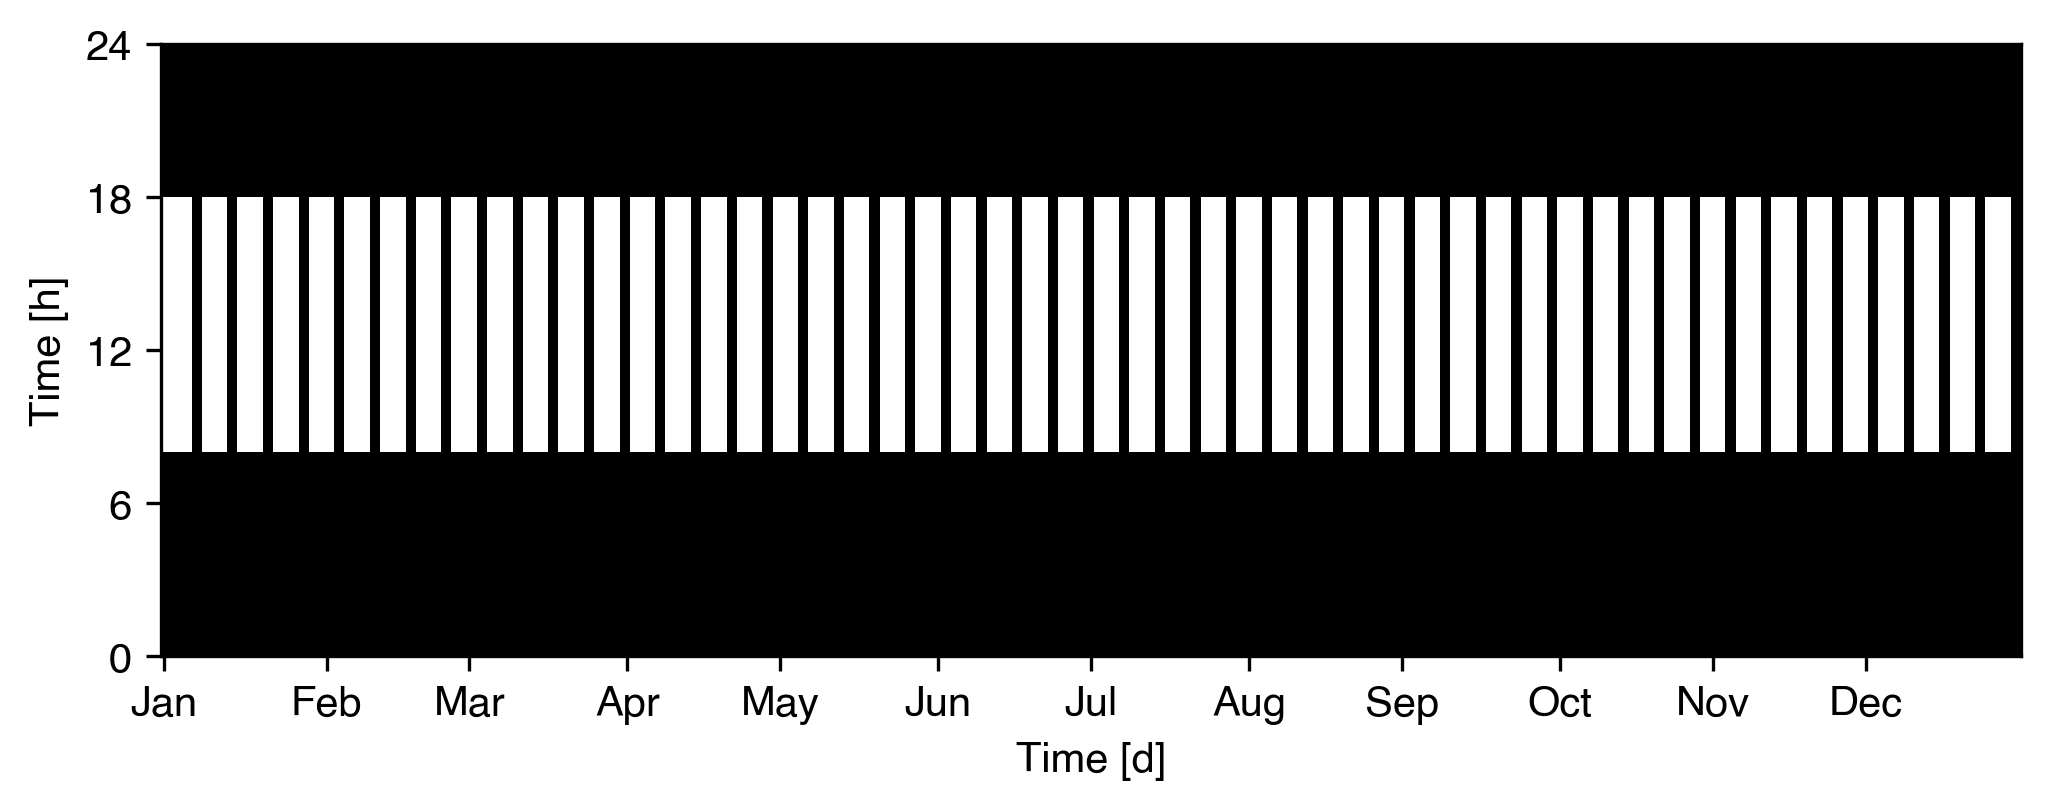

In [14]:
schedule_workingday = np.array([0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0])
schedule_weekendday = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
schedule_workingweek = np.tile(schedule_workingday, 5)
schedule_weekend = np.tile(schedule_weekendday, 2)
schedule_weekly = np.concatenate([schedule_workingweek, schedule_weekend])

schedule_yearly = np.concatenate([schedule_workingday, np.tile(schedule_weekly, 52)])

daily_plot(schedule_yearly)

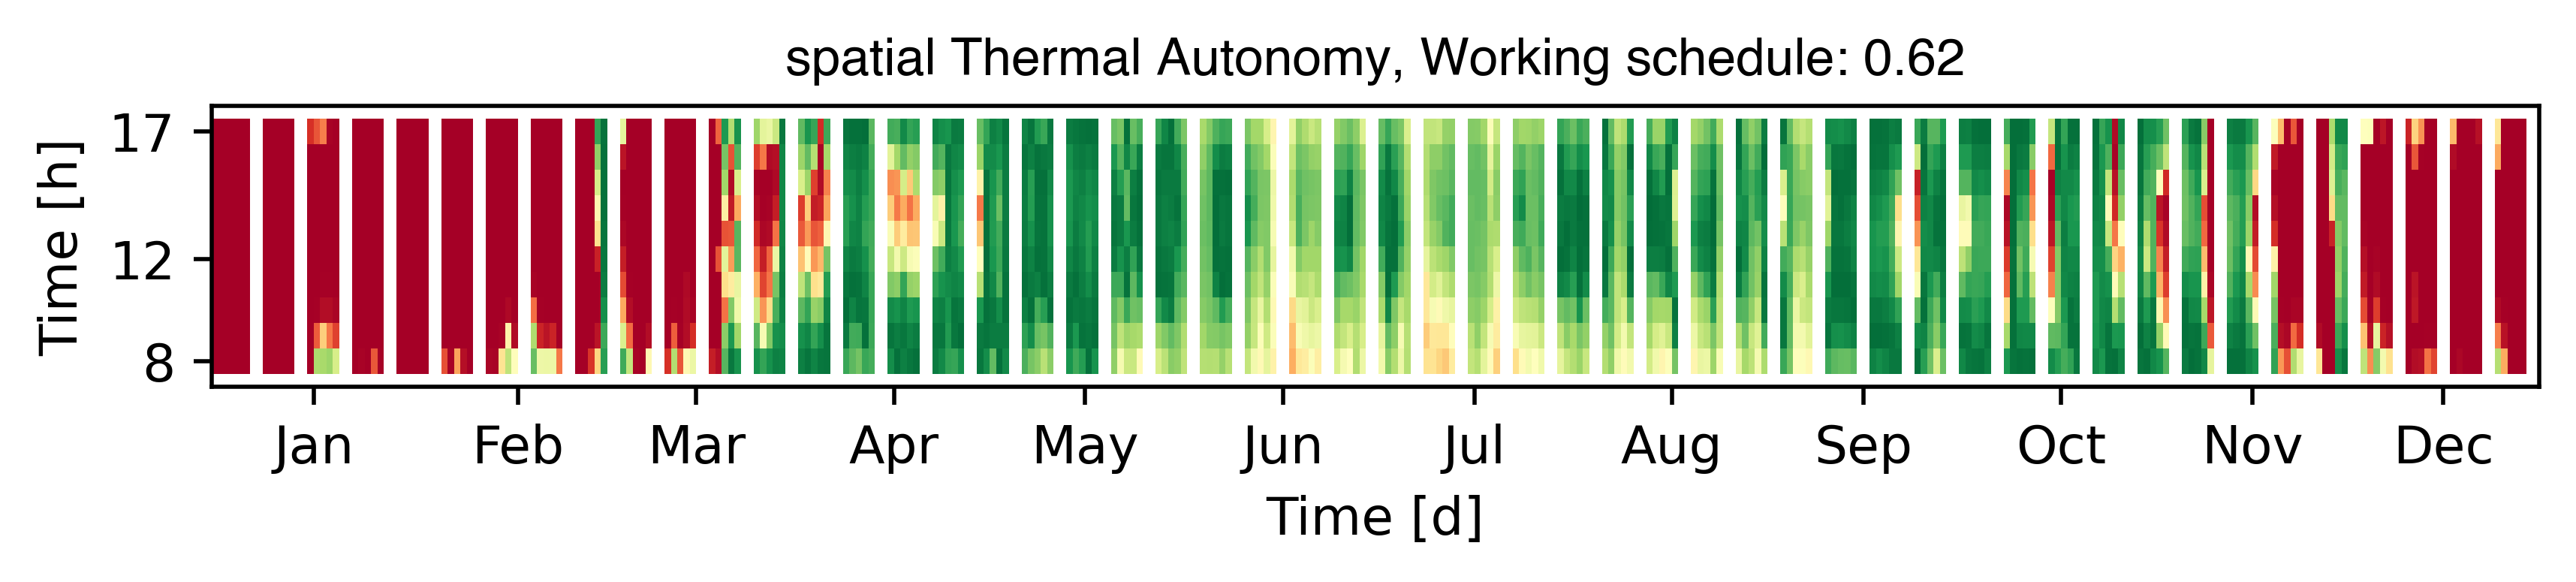

In [15]:
import numpy.ma as ma

# field = mlPredictions
# var_name = 'ml'

# field = pmvPredictions
# var_name = 'pmv'

field = adaptivePredictions
var_name = 'adaptive'

autonomy_working = np.where(schedule_yearly == 1, compute_sta(field)[1], 100) # when working hour prediction, else 100

# Define a condition (e.g., hide values less than 0.5)
condition = autonomy_working == 100

# Create a masked array where True values in the condition are transparent (alpha=0)
masked_data = ma.masked_array(autonomy_working, condition)

# calculate sTA for working hours only
sta_data = np.where(masked_data.data != 100, compute_sta(field)[1].round(), 0) # round up, because continuous not possible with adaptive
working_sta = sum(sta_data) / sum(schedule_yearly)

# Create a colormap with transparency (alpha)
cmap = plt.cm.RdYlGn
cmap.set_bad(alpha=0)  # Set alpha for masked values to 0 (transparent)

# Plot the masked data
plt.figure(figsize=(8,8), dpi=500)
plt.imshow(masked_data.reshape((24,365), order = 'F'),aspect=4, cmap=cmap,vmax=1,vmin=0)
plt.ylim([7,18])

xticks = [15.5, (32+15.5), (60+15.5),(91+15.5),(15.5+121),(15.5+152),(15.5+182),(15.5+213),(15.5+243),(15.5+274),(15.5+304),(15.5+334)]
xlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

yticks = [8,12, 17]

plt.xticks(ticks=xticks,labels=xlabels)
plt.yticks(ticks=yticks)

plt.xlabel("Time [d]")
plt.ylabel("Time [h]")

plt.title(f"spatial Thermal Autonomy, Working schedule: {working_sta.round(decimals=2)}", font='Helvetica')

plt.show()